## 1. Read Data

In [1]:
import pandas as pd
data = pd.read_csv("/Users/ruijingchen/Desktop/628/04 Spotify/data/episodes_list_mini.csv")
data.head()

,Podcast_ID,Audio_Preview_URL,Description,Duration_MS,External_URL,Href,Episode_ID,Image_640,Image_300,Image_64,Languages,Name,Release_Date
0,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book 3, Part 2; by To...",15030692,https://open.spotify.com/episode/50cMpkihODgds...,https://api.spotify.com/v1/episodes/50cMpkihOD...,50cMpkihODgdsKVKJvcZ1b,https://i.scdn.co/image/ab6765630000ba8a92d657...,https://i.scdn.co/image/ab67656300005f1f92d657...,https://i.scdn.co/image/ab6765630000f68d92d657...,['en'],"The Return of the King - Book 3, Part 2",2023-08-30
1,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book 3, Part 1; by To...",28423954,https://open.spotify.com/episode/4WCvmLhmDTDT2...,https://api.spotify.com/v1/episodes/4WCvmLhmDT...,4WCvmLhmDTDT2XShxombXa,https://i.scdn.co/image/ab6765630000ba8a350f33...,https://i.scdn.co/image/ab67656300005f1f350f33...,https://i.scdn.co/image/ab6765630000f68d350f33...,['en'],"The Return of the King - Book 3, Part 1",2023-08-30
2,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book 2, Part 2; by Tolkien. R...",30055072,https://open.spotify.com/episode/0c6d9LdV8YCUC...,https://api.spotify.com/v1/episodes/0c6d9LdV8Y...,0c6d9LdV8YCUCvWINpZ2ro,https://i.scdn.co/image/ab6765630000ba8a37de6f...,https://i.scdn.co/image/ab67656300005f1f37de6f...,https://i.scdn.co/image/ab6765630000f68d37de6f...,['en'],"The Two Towers - Book 2, Part 2",2023-08-29
3,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book 2, Part 1; by Tolkien. R...",29436330,https://open.spotify.com/episode/0EYsddxf5Gtc7...,https://api.spotify.com/v1/episodes/0EYsddxf5G...,0EYsddxf5Gtc7eJOMvFHqs,https://i.scdn.co/image/ab6765630000ba8a173a69...,https://i.scdn.co/image/ab67656300005f1f173a69...,https://i.scdn.co/image/ab6765630000f68d173a69...,['en'],"The Two Towers - Book 2, Part 1",2023-01-24
4,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Fellowship of the Ring : book 1, part 2; b...",31584312,https://open.spotify.com/episode/2dOF8OhhgHcyN...,https://api.spotify.com/v1/episodes/2dOF8OhhgH...,2dOF8OhhgHcyNbNdoTkV3c,https://i.scdn.co/image/ab6765630000ba8ac0f170...,https://i.scdn.co/image/ab67656300005f1fc0f170...,https://i.scdn.co/image/ab6765630000f68dc0f170...,['en'],"The Fellowship of the Ring - Book 1, Part 2",2022-12-14


In [20]:
data['Podcast_ID'].nunique()

3225

In [2]:
data.shape

(35087, 13)

## 2. Data preprocess

### Delete non-english rows

In [3]:
from langdetect import detect, DetectorFactory
import pandas as pd

# set seed
DetectorFactory.seed = 0

def remove_non_english_rows(data, column_name):
    def detect_language(text):
        try:
            return detect(text)  # detect language
        except:
            return 'unknown'

    data['Language'] = data[column_name].apply(detect_language)
    filtered_data = data[data['Language'] == 'en'].copy()
    filtered_data.drop(columns=['Language'], inplace=True)

    return filtered_data

data = remove_non_english_rows(data, 'Description')


data.shape

(31421, 13)

### Drop NA

In [4]:
data = data.dropna(subset=['Description'])
data.shape

(31421, 13)

### Delete URL

In [5]:
import re

def remove_urls(text):
    # regular expression
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

data['Description'] = data['Description'].apply(remove_urls)

### Delete number

In [6]:
data['Description'] = data['Description'].apply(lambda x: re.sub(r'\d+', '', x))

## 3.Use TF-IDF method extract key words，delete useless words.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# stop words
custom_stop_words = ['et', 'la', 'en', 'le', 'pour', 'les', 'des', 'est', 'du', 'une']

# TF-IDF
def extract_tfidf_keywords(descriptions, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    vectorizer.set_params(stop_words=custom_stop_words + list(vectorizer.get_stop_words()))
    
    X = vectorizer.fit_transform(descriptions)
    feature_names = vectorizer.get_feature_names_out()

    keywords_per_row = []
    for row in X.toarray():
        top_indices = row.argsort()[-top_n:][::-1]
        keywords = [feature_names[i] for i in top_indices]
        keywords_per_row.append(", ".join(keywords))
    return keywords_per_row

data['Description'] = data['Description'].fillna('').astype(str)
tfidf_keywords = extract_tfidf_keywords(data['Description'])
data['TF-IDF Keywords'] = tfidf_keywords

print(data[['Description', 'TF-IDF Keywords']].head())


                                         Description  \
0  The Return of the King - Book , Part ; by Tolk...   
1  The Return of the King - Book , Part ; by Tolk...   
2  The Two Towers - Book , Part ; by Tolkien. Rea...   
3  The Two Towers - Book , Part ; by Tolkien. Rea...   
4  The Fellowship of the Ring : book , part ; by ...   

                               TF-IDF Keywords  
0      use, audiobook, purposes, king, comment  
1      use, audiobook, purposes, king, comment  
2  use, audiobook, purposes, comment, teaching  
3  use, audiobook, purposes, comment, teaching  
4  use, audiobook, purposes, comment, teaching  


## 4.LDA

### Determine the number of clusters using the elbow method

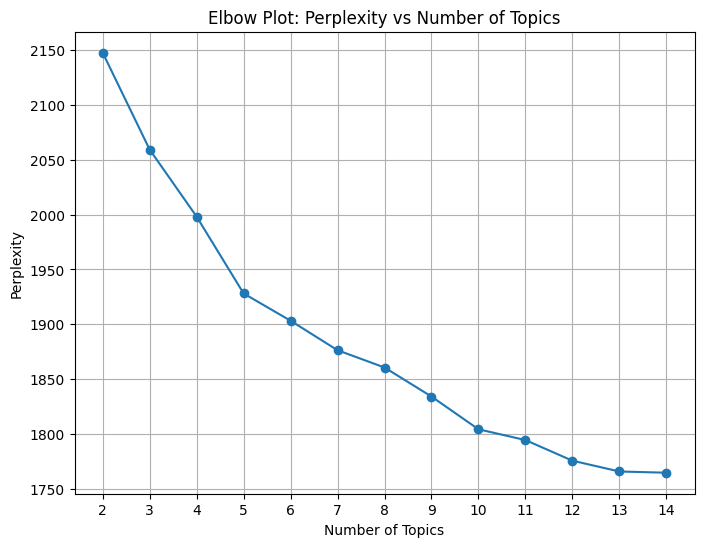

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Step 1: Convert to word frequency matrix (DTM)
vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=2,
    max_features=5000
)
dtm = vectorizer.fit_transform(data['Description'])

# Step 2: Testing Perplexity for different number of topics
topic_numbers = list(range(2, 15))
perplexities = []

for num_topics in topic_numbers:
    lda_model = LatentDirichletAllocation(
        n_components=num_topics,
        random_state=42,
        max_iter=10,
        learning_method='batch',
        learning_decay=0.7,
        n_jobs=-1
    )
    lda_model.fit(dtm)
    perplexities.append(lda_model.perplexity(dtm))

# Step 3: Draw Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(topic_numbers, perplexities, marker='o')
plt.title('Elbow Plot: Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(topic_numbers)
plt.grid()
plt.show()

### LDA model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
#LDA model
num_topics = 9
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Step 1: Convert to word frequency matrix (DTM)
vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=2,
    max_features=5000
)
dtm = vectorizer.fit_transform(data['Description'])

lda_model.fit(dtm)

feature_names = vectorizer.get_feature_names_out()

# Print topic key words
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print("LDA Topics and Top Keywords:")
print_topics(lda_model, feature_names)

LDA Topics and Top Keywords:
Topic 1:
code, use, com, visit, free, sleep, fanduel, app, new, promo

Topic 2:
visit, learn, ad, choices, adchoices, new, fm, megaphone, history, music

Topic 3:
episode, journey, life, importance, personal, insights, challenges, self, shares, health

Topic 4:
week, episode, game, podcast, season, vs, sports, discuss, team, talk

Topic 5:
episode, podcast, life, free, like, want, help, time, know, instagram

Topic 6:
privacy, com, information, acast, design, hosted, ai, listener, episode, omnystudio

Topic 7:
health, dr, university, training, running, episode, science, nutrition, research, podcast

Topic 8:
business, episode, marketing, financial, industry, new, podcast, brand, company, market

Topic 9:
podcast, com, episode, follow, instagram, support, youtube, twitter, patreon, join



In [14]:
# Write topics and key wordsb to txt file.
num_words = 10

with open("/Users/ruijingchen/Desktop/628/04 Spotify/lda_topics.txt", "w") as f:
    for topic_idx, topic in enumerate(lda_model.components_):
        f.write(f"Topic {topic_idx + 1}:\n")
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        f.write(", ".join(top_words) + "\n\n")

### Caculate topic distribuction

In [15]:
# Add result to data
topic_distribution = lda_model.transform(dtm)
data['Dominant Topic'] = topic_distribution.argmax(axis=1)
data['Topic Distribution'] = topic_distribution.tolist()

data.head()

,Podcast_ID,Audio_Preview_URL,Description,Duration_MS,External_URL,Href,Episode_ID,Image_640,Image_300,Image_64,Languages,Name,Release_Date,TF-IDF Keywords,Dominant Topic,Topic Distribution
0,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",15030692,https://open.spotify.com/episode/50cMpkihODgds...,https://api.spotify.com/v1/episodes/50cMpkihOD...,50cMpkihODgdsKVKJvcZ1b,https://i.scdn.co/image/ab6765630000ba8a92d657...,https://i.scdn.co/image/ab67656300005f1f92d657...,https://i.scdn.co/image/ab6765630000f68d92d657...,['en'],"The Return of the King - Book 3, Part 2",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00..."
1,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",28423954,https://open.spotify.com/episode/4WCvmLhmDTDT2...,https://api.spotify.com/v1/episodes/4WCvmLhmDT...,4WCvmLhmDTDT2XShxombXa,https://i.scdn.co/image/ab6765630000ba8a350f33...,https://i.scdn.co/image/ab67656300005f1f350f33...,https://i.scdn.co/image/ab6765630000f68d350f33...,['en'],"The Return of the King - Book 3, Part 1",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00..."
2,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",30055072,https://open.spotify.com/episode/0c6d9LdV8YCUC...,https://api.spotify.com/v1/episodes/0c6d9LdV8Y...,0c6d9LdV8YCUCvWINpZ2ro,https://i.scdn.co/image/ab6765630000ba8a37de6f...,https://i.scdn.co/image/ab67656300005f1f37de6f...,https://i.scdn.co/image/ab6765630000f68d37de6f...,['en'],"The Two Towers - Book 2, Part 2",2023-08-29,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004..."
3,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",29436330,https://open.spotify.com/episode/0EYsddxf5Gtc7...,https://api.spotify.com/v1/episodes/0EYsddxf5G...,0EYsddxf5Gtc7eJOMvFHqs,https://i.scdn.co/image/ab6765630000ba8a173a69...,https://i.scdn.co/image/ab67656300005f1f173a69...,https://i.scdn.co/image/ab6765630000f68d173a69...,['en'],"The Two Towers - Book 2, Part 1",2023-01-24,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004..."
4,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Fellowship of the Ring : book , part ; by ...",31584312,https://open.spotify.com/episode/2dOF8OhhgHcyN...,https://api.spotify.com/v1/episodes/2dOF8OhhgH...,2dOF8OhhgHcyNbNdoTkV3c,https://i.scdn.co/image/ab6765630000ba8ac0f170...,https://i.scdn.co/image/ab67656300005f1fc0f170...,https://i.scdn.co/image/ab6765630000f68dc0f170...,['en'],"The Fellowship of the Ring - Book 1, Part 2",2022-12-14,"use, audiobook, purposes, comment, teaching",0,"[0.8189315871178087, 0.1532775598843231, 0.003..."


### Name each topic

In [16]:
# Topic names as per the second image
topic_names = [
    "Finance and Marketing",
    "Privacy and History",
    "Health and Relationships",
    "Sleep and Fitness",
    "Music and Entertainment",
    "Personal Development",
    "Sports",
    "Social Media",
    "Education and Choices"
]

# Map Sentiment_Label_Encoded to Topic_Name
data['Topic_Name'] = data['Dominant Topic'].map(lambda x: topic_names[x])

data.head()

,Podcast_ID,Audio_Preview_URL,Description,Duration_MS,External_URL,Href,Episode_ID,Image_640,Image_300,Image_64,Languages,Name,Release_Date,TF-IDF Keywords,Dominant Topic,Topic Distribution,Topic_Name
0,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",15030692,https://open.spotify.com/episode/50cMpkihODgds...,https://api.spotify.com/v1/episodes/50cMpkihOD...,50cMpkihODgdsKVKJvcZ1b,https://i.scdn.co/image/ab6765630000ba8a92d657...,https://i.scdn.co/image/ab67656300005f1f92d657...,https://i.scdn.co/image/ab6765630000f68d92d657...,['en'],"The Return of the King - Book 3, Part 2",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing
1,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",28423954,https://open.spotify.com/episode/4WCvmLhmDTDT2...,https://api.spotify.com/v1/episodes/4WCvmLhmDT...,4WCvmLhmDTDT2XShxombXa,https://i.scdn.co/image/ab6765630000ba8a350f33...,https://i.scdn.co/image/ab67656300005f1f350f33...,https://i.scdn.co/image/ab6765630000f68d350f33...,['en'],"The Return of the King - Book 3, Part 1",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing
2,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",30055072,https://open.spotify.com/episode/0c6d9LdV8YCUC...,https://api.spotify.com/v1/episodes/0c6d9LdV8Y...,0c6d9LdV8YCUCvWINpZ2ro,https://i.scdn.co/image/ab6765630000ba8a37de6f...,https://i.scdn.co/image/ab67656300005f1f37de6f...,https://i.scdn.co/image/ab6765630000f68d37de6f...,['en'],"The Two Towers - Book 2, Part 2",2023-08-29,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing
3,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",29436330,https://open.spotify.com/episode/0EYsddxf5Gtc7...,https://api.spotify.com/v1/episodes/0EYsddxf5G...,0EYsddxf5Gtc7eJOMvFHqs,https://i.scdn.co/image/ab6765630000ba8a173a69...,https://i.scdn.co/image/ab67656300005f1f173a69...,https://i.scdn.co/image/ab6765630000f68d173a69...,['en'],"The Two Towers - Book 2, Part 1",2023-01-24,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing
4,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Fellowship of the Ring : book , part ; by ...",31584312,https://open.spotify.com/episode/2dOF8OhhgHcyN...,https://api.spotify.com/v1/episodes/2dOF8OhhgH...,2dOF8OhhgHcyNbNdoTkV3c,https://i.scdn.co/image/ab6765630000ba8ac0f170...,https://i.scdn.co/image/ab67656300005f1fc0f170...,https://i.scdn.co/image/ab6765630000f68dc0f170...,['en'],"The Fellowship of the Ring - Book 1, Part 2",2022-12-14,"use, audiobook, purposes, comment, teaching",0,"[0.8189315871178087, 0.1532775598843231, 0.003...",Finance and Marketing


## 5.The first indicator [Entropy of Topic Distribution]: a small Topic Entropy means that the topic is distributed under one topic, and a large one means that it is related to multiple topics.

In [17]:
import numpy as np

def calculate_entropy(prob_dist):
    prob_dist = np.array(prob_dist)
    return -np.sum(prob_dist * np.log2(prob_dist + 1e-10))  # 避免 log(0)

# Calculate entropy for each row based on the Topic Distribution
data['Topic Entropy'] = data['Topic Distribution'].apply(calculate_entropy)

def normalize_entropy(entropy, min_entropy, max_entropy):
    return (2 * (entropy - min_entropy) / (max_entropy - min_entropy)) - 1

# 计算最小和最大熵值
min_entropy = data['Topic Entropy'].min()
max_entropy = data['Topic Entropy'].max()

# 对 Topic Entropy 列进行标准化
data['Normalized Entropy'] = data['Topic Entropy'].apply(lambda x: normalize_entropy(x, min_entropy, max_entropy))

# 输出结果
data.head()

,Podcast_ID,Audio_Preview_URL,Description,Duration_MS,External_URL,Href,Episode_ID,Image_640,Image_300,Image_64,Languages,Name,Release_Date,TF-IDF Keywords,Dominant Topic,Topic Distribution,Topic_Name,Topic Entropy,Normalized Entropy
0,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",15030692,https://open.spotify.com/episode/50cMpkihODgds...,https://api.spotify.com/v1/episodes/50cMpkihOD...,50cMpkihODgdsKVKJvcZ1b,https://i.scdn.co/image/ab6765630000ba8a92d657...,https://i.scdn.co/image/ab67656300005f1f92d657...,https://i.scdn.co/image/ab6765630000f68d92d657...,['en'],"The Return of the King - Book 3, Part 2",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing,0.965020,-0.402562
1,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",28423954,https://open.spotify.com/episode/4WCvmLhmDTDT2...,https://api.spotify.com/v1/episodes/4WCvmLhmDT...,4WCvmLhmDTDT2XShxombXa,https://i.scdn.co/image/ab6765630000ba8a350f33...,https://i.scdn.co/image/ab67656300005f1f350f33...,https://i.scdn.co/image/ab6765630000f68d350f33...,['en'],"The Return of the King - Book 3, Part 1",2023-08-30,"use, audiobook, purposes, king, comment",0,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing,0.965020,-0.402562
2,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",30055072,https://open.spotify.com/episode/0c6d9LdV8YCUC...,https://api.spotify.com/v1/episodes/0c6d9LdV8Y...,0c6d9LdV8YCUCvWINpZ2ro,https://i.scdn.co/image/ab6765630000ba8a37de6f...,https://i.scdn.co/image/ab67656300005f1f37de6f...,https://i.scdn.co/image/ab6765630000f68d37de6f...,['en'],"The Two Towers - Book 2, Part 2",2023-08-29,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing,0.893531,-0.448036
3,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",29436330,https://open.spotify.com/episode/0EYsddxf5Gtc7...,https://api.spotify.com/v1/episodes/0EYsddxf5G...,0EYsddxf5Gtc7eJOMvFHqs,https://i.scdn.co/image/ab6765630000ba8a173a69...,https://i.scdn.co/image/ab67656300005f1f173a69...,https://i.scdn.co/image/ab6765630000f68d173a69...,['en'],"The Two Towers - Book 2, Part 1",2023-01-24,"use, audiobook, purposes, comment, teaching",0,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing,0.893531,-0.448036
4,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Fellowship of the Ring : book , part ; by ...",31584312,https://open.spotify.com/episode/2dOF8OhhgHcyN...,https://api.spotify.com/v1/episodes/2dOF8OhhgH...,2dOF8OhhgHcyNbNdoTkV3c,https://i.scdn.co/image/ab6765630000ba8ac0f170...,https://i.scdn.co/image/ab67656300005f1fc0f170...,https://i.scdn.co/image/ab6765630000f68dc0f170...,['en'],"The Fellowship of the Ring - Book 1, Part 2",2022-12-14,"use, audiobook, purposes, comment, teaching",0,"[0.8189315871178087, 0.1532775598843231, 0.003...",Finance and Marketing,0.872416,-0.461468


## 6. Indicator 2: emotional disposition

                                             Description  Positive  Neutral  \
0      The Return of the King - Book , Part ; by Tolk...     0.069    0.887   
1      The Return of the King - Book , Part ; by Tolk...     0.069    0.887   
2      The Two Towers - Book , Part ; by Tolkien. Rea...     0.071    0.884   
3      The Two Towers - Book , Part ; by Tolkien. Rea...     0.071    0.884   
4      The Fellowship of the Ring : book , part ; by ...     0.035    0.920   
...                                                  ...       ...      ...   
35082  On this episode of the Pro Wrestling Extreme T...     0.202    0.755   
35083  Happy New Years and welcome to episode # of ! ...     0.226    0.774   
35084  Tune in and see who wins a Shithead Award from...     0.365    0.499   
35085  Tonights show we give you our top  wrestlers! ...     0.271    0.729   
35086  Take a listen! Great show! ##prowrestling ##wr...     0.210    0.628   

       Negative  Compound Sentiment_Label  
0      

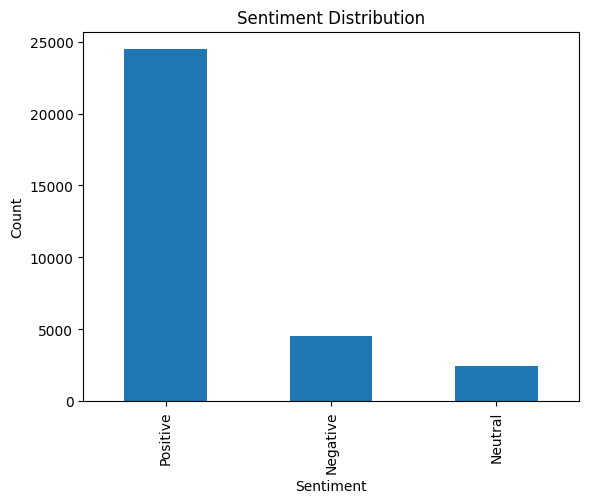

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(description):
    if pd.isnull(description): 
        return {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0}
    sentiment = analyzer.polarity_scores(description)
    return sentiment

data['Sentiment'] = data['Description'].apply(analyze_sentiment)

data['Positive'] = data['Sentiment'].apply(lambda x: x['pos'])
data['Neutral'] = data['Sentiment'].apply(lambda x: x['neu'])
data['Negative'] = data['Sentiment'].apply(lambda x: x['neg'])
data['Compound'] = data['Sentiment'].apply(lambda x: x['compound'])

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment_Label'] = data['Compound'].apply(classify_sentiment)

print(data[['Description', 'Positive', 'Neutral', 'Negative', 'Compound', 'Sentiment_Label']])

data['Sentiment_Label'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
data.head()

,Podcast_ID,Audio_Preview_URL,Description,Duration_MS,External_URL,Href,Episode_ID,Image_640,Image_300,Image_64,...,Topic Distribution,Topic_Name,Topic Entropy,Normalized Entropy,Sentiment,Positive,Neutral,Negative,Compound,Sentiment_Label
0,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",15030692,https://open.spotify.com/episode/50cMpkihODgds...,https://api.spotify.com/v1/episodes/50cMpkihOD...,50cMpkihODgdsKVKJvcZ1b,https://i.scdn.co/image/ab6765630000ba8a92d657...,https://i.scdn.co/image/ab67656300005f1f92d657...,https://i.scdn.co/image/ab6765630000f68d92d657...,...,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing,0.965020,-0.402562,"{'neg': 0.044, 'neu': 0.887, 'pos': 0.069, 'co...",0.069,0.887,0.044,0.1779,Positive
1,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Return of the King - Book , Part ; by Tolk...",28423954,https://open.spotify.com/episode/4WCvmLhmDTDT2...,https://api.spotify.com/v1/episodes/4WCvmLhmDT...,4WCvmLhmDTDT2XShxombXa,https://i.scdn.co/image/ab6765630000ba8a350f33...,https://i.scdn.co/image/ab67656300005f1f350f33...,https://i.scdn.co/image/ab6765630000f68d350f33...,...,"[0.7740375824560087, 0.19913241058329262, 0.00...",Finance and Marketing,0.965020,-0.402562,"{'neg': 0.044, 'neu': 0.887, 'pos': 0.069, 'co...",0.069,0.887,0.044,0.1779,Positive
2,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",30055072,https://open.spotify.com/episode/0c6d9LdV8YCUC...,https://api.spotify.com/v1/episodes/0c6d9LdV8Y...,0c6d9LdV8YCUCvWINpZ2ro,https://i.scdn.co/image/ab6765630000ba8a37de6f...,https://i.scdn.co/image/ab67656300005f1f37de6f...,https://i.scdn.co/image/ab6765630000f68d37de6f...,...,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing,0.893531,-0.448036,"{'neg': 0.045, 'neu': 0.884, 'pos': 0.071, 'co...",0.071,0.884,0.045,0.1779,Positive
3,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Two Towers - Book , Part ; by Tolkien. Rea...",29436330,https://open.spotify.com/episode/0EYsddxf5Gtc7...,https://api.spotify.com/v1/episodes/0EYsddxf5G...,0EYsddxf5Gtc7eJOMvFHqs,https://i.scdn.co/image/ab6765630000ba8a173a69...,https://i.scdn.co/image/ab67656300005f1f173a69...,https://i.scdn.co/image/ab6765630000f68d173a69...,...,"[0.8123509984778885, 0.1588308416347511, 0.004...",Finance and Marketing,0.893531,-0.448036,"{'neg': 0.045, 'neu': 0.884, 'pos': 0.071, 'co...",0.071,0.884,0.045,0.1779,Positive
4,5I215mpoRFa8ZbGcNtdMCv,https://podz-content.spotifycdn.com/audio/clip...,"The Fellowship of the Ring : book , part ; by ...",31584312,https://open.spotify.com/episode/2dOF8OhhgHcyN...,https://api.spotify.com/v1/episodes/2dOF8OhhgH...,2dOF8OhhgHcyNbNdoTkV3c,https://i.scdn.co/image/ab6765630000ba8ac0f170...,https://i.scdn.co/image/ab67656300005f1fc0f170...,https://i.scdn.co/image/ab6765630000f68dc0f170...,...,"[0.8189315871178087, 0.1532775598843231, 0.003...",Finance and Marketing,0.872416,-0.461468,"{'neg': 0.044, 'neu': 0.92, 'pos': 0.035, 'com...",0.035,0.920,0.044,-0.1531,Negative


In [32]:
data.head(100).to_csv("/Users/ruijingchen/Desktop/628/data.csv")

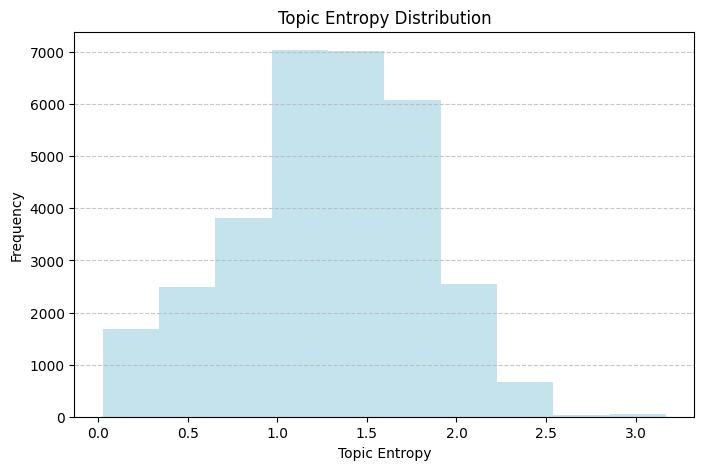

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(data["Topic Entropy"], bins=10, color='lightblue', alpha=0.7)
plt.title("Topic Entropy Distribution")
plt.xlabel("Topic Entropy")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

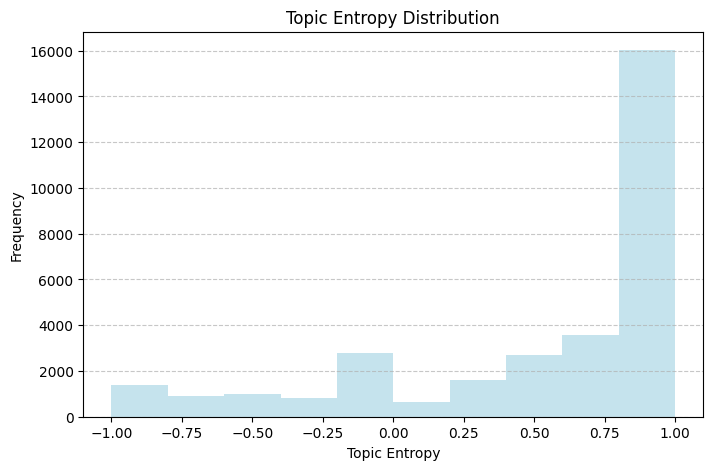

In [30]:
plt.figure(figsize=(8, 5))
plt.hist(data["Compound"], bins=10, color='lightblue', alpha=0.7)
plt.title("Topic Entropy Distribution")
plt.xlabel("Topic Entropy")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()